# Stats analysis of chapter 2

Looking at Fluctuating Asymmetry (FA) as a function of distance to range edge and forest cover

### Load packages

In [22]:
library(brms) # for Bayesian analysis
library(tidyverse) # for tidy code
library(egg) # for nice professional figures
library(lme4) # for frequentist analysis
library(lmerTest) # for p-values
library(GGally) # for ggpairs
library(tidybayes) # for plotting bayes models

library(magrittr)
library(modelr)
library(ggdist)
library(cowplot)
library(rstan)
library(ggrepel)
library(RColorBrewer)
library(posterior)

Installing package into ‘/usr/local/lib/R/4.1/site-library’
(as ‘lib’ is unspecified)


Attaching package: ‘magrittr’


The following object is masked from ‘package:purrr’:

    set_names


The following object is masked from ‘package:tidyr’:

    extract



Attaching package: ‘ggdist’


The following objects are masked from ‘package:brms’:

    dstudent_t, pstudent_t, qstudent_t, rstudent_t


Loading required package: StanHeaders

rstan (Version 2.21.2, GitRev: 2e1f913d3ca3)

For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)


Attaching package: ‘rstan’


The following object is masked from ‘package:magrittr’:

    extract


The following object is masked from ‘package:tidyr’:

    extract


This is posterior version 1.0.1


Attaching package: ‘posterior’


The following objects are masked from ‘package:rstan’:

In [2]:
getwd()

[1] "/Users/tom/OneDrive - Imperial College London/1.PHD/2.R-dir/2.chapter/2.notebook"

### Load forest cover data

In [3]:
FC <- read_csv("../2.data_cleaned/FC_calculated.csv", 
               col_types = cols(
                  species = col_character(),  # load column as character
                  bird_id = col_character()
                    )) %>% dplyr::select(-"X0")

In [4]:
# head(FC)

#### Make sure that all NAs in column percentage of FC are zeros
The function used to calculate FC in the previous script would give NAs if the landscape metric 'proportion of class' (3 for FC in MAPBIOMAS) was innexistent. That means that forest cover was innexistent, therefore NA = 0%. That happened often for smaller buffer radius like 100 m.  

In [5]:
FC$FC_percentage.value[is.na(FC$FC_percentage.value)] <- 0

### Load distance to range edge data

In [6]:
dist <- read_csv("../2.data_cleaned/NHM-MZUSP_dist2edge_data.csv")%>%
  dplyr::select(-c(13:14)) %>%  # remove unnecessary columns
  dplyr::select(-c("feather_tail", "distance", "sex")) %>% # remove some more unnecessary columns
  filter(inrange == TRUE) # keep only specimens inside the range


── Column specification ────────────────────────────────────────────────────────
cols(
  species = col_character(),
  subspecies = col_character(),
  date_collected = col_double(),
  bird_id = col_character(),
  lon_dd = col_double(),
  lat_dd = col_double(),
  location = col_character(),
  sex = col_character(),
  feather_tail = col_character(),
  source = col_character(),
  distance = col_double(),
  inrange = col_logical(),
  in_costal_margin = col_logical(),
  distance_sgn = col_double(),
  dist_km = col_double()
)




In [7]:
 head(dist)

species                  subspecies                             
1 Automolus_leucophthalmus Automolus_leucophthalmus_leucophthalmus
2 Automolus_leucophthalmus Automolus_leucophthalmus_sulphuracens  
3 Automolus_leucophthalmus Automolus_leucophthalmus_sulphuracens  
4 Automolus_leucophthalmus Automolus_leucophthalmus_sulphuracens  
5 Automolus_leucophthalmus Automolus_leucophthalmus_sulphuracens  
6 Automolus_leucophthalmus Automolus_leucophthalmus_sulphuracens  
  date_collected bird_id lon_dd    lat_dd   
1 2016           104089  -48.85236 -27.81322
2 2010           91247   -49.80011 -28.70533
3 2010           91248   -48.23111 -25.20336
4 2002           75697   -49.80359 -23.87488
5 2002           75631   -50.00111 -23.93333
6 2012           93205   -45.88944 -23.65417
  location                                                  source inrange
1 Aguas Mornas, SC, Brasil                                  MZUSP  TRUE   
2 Morro Grande, Nova Roma, Pousada Rancho Fundo, SC, Brasil MZUSP  TRUE   
3 Guaraqueçaba, Utinga, PR, Brasil                          MZUSP  TRUE   
4 Wenceslau Bras, PR, Brasil                                MZUSP  TRUE   
5 Fazenda Chapadão, Pinhalão, PR, Brasil                    MZUSP  TRUE   
6 Estacao Biologica de Boraceia, Salesópolis, SP, Brasil    MZUSP  TRUE   
  dist_km 
1 573.7955
2 438.8556
3 737.7786
4 521.2166
5 512.9594
6 689.6465

### Load FA data

In [8]:
# load fluctuating asymmetry data
FA <-read_csv("../2.data_cleaned/fa/NHM-MZUSP_fa_wing_tarsus.csv")


── Column specification ────────────────────────────────────────────────────────
cols(
  species = col_character(),
  subspecies = col_character(),
  date_collected = col_double(),
  bird_id = col_character(),
  lon_dd = col_double(),
  lat_dd = col_double(),
  sex = col_character(),
  source = col_character(),
  type = col_character(),
  unit = col_character(),
  mean_l = col_double(),
  mean_r = col_double(),
  sd_l = col_double(),
  sd_r = col_double(),
  fa_left_right = col_double(),
  fa_ratio = col_double(),
  fa_abs_mm = col_double()
)




In [9]:
head(FA)

species                  subspecies                             
1 Automolus_leucophthalmus Automolus_leucophthalmus_leucophthalmus
2 Automolus_leucophthalmus Automolus_leucophthalmus_leucophthalmus
3 Automolus_leucophthalmus Automolus_leucophthalmus_sulphuracens  
4 Automolus_leucophthalmus Automolus_leucophthalmus_sulphuracens  
5 Automolus_leucophthalmus Automolus_leucophthalmus_sulphuracens  
6 Automolus_leucophthalmus Automolus_leucophthalmus_sulphuracens  
  date_collected bird_id lon_dd    lat_dd    sex    source type unit mean_l  
1 2016           104089  -48.85236 -27.81322 female MZUSP  w    mm   88.50000
2 2016           104089  -48.85236 -27.81322 female MZUSP  t    mm   22.88667
3 2010           91247   -49.80011 -28.70533 na     MZUSP  w    mm   89.97000
4 2010           91247   -49.80011 -28.70533 na     MZUSP  t    mm   22.70333
5 2010           91248   -48.23111 -25.20336 female MZUSP  w    mm   83.42333
6 2010           91248   -48.23111 -25.20336 female MZUSP  t    mm   21.84000
  mean_r   sd_l       sd_r       fa_left_right fa_ratio  fa_abs_mm
1 87.84000 0.05000000 0.08717798  0.6600000    1.0075137 0.6600000
2 23.14000 0.08020806 0.14422205 -0.2533333    0.9890521 0.2533333
3 90.95333 0.01000000 0.05033223 -0.9833333    0.9891886 0.9833333
4 21.84333 0.12662280 0.05507571  0.8600000    1.0393713 0.8600000
5 83.01000 0.13576941 0.05000000  0.4133333    1.0049793 0.4133333
6 21.24667 0.03464102 0.14502873  0.5933333    1.0279259 0.5933333

### Manipulate FA data for analysis

Join FA dataset to the distances dataset

In [10]:
FA_data <- dist %>% dplyr::left_join(FA) 

Joining, by = c("species", "subspecies", "date_collected", "bird_id", "lon_dd", "lat_dd", "source")



Now join the FA and dist data set to the forest cover dataset and remove Thalurania glaucopis tarsus. This species has very short tarsus covered by feathers, which impeded me to measure it with any precision, as I could not see the back notch of the intertarsal joint without damaging the specimen. Therefore tarsus shows as 9999 in the original dataset and as 0 in the dataset used here.  

In [11]:
FA_FC_data <- FA_data %>% dplyr::left_join(FC) %>%
    filter(source == "MZUSP")%>%
    mutate(to_remove = ifelse(species == "Thalurania_glaucopis" & type == "t", 1,0))%>% # first transform all Thalurania AND tarsus to = 1 and everything else to =0
    filter(to_remove == 0) # keep only =0 observations

names(FA_FC_data)

Joining, by = c("species", "bird_id", "lon_dd", "lat_dd", "dist_km")



[1] "species"             "subspecies"          "date_collected"     
 [4] "bird_id"             "lon_dd"              "lat_dd"             
 [7] "location"            "source"              "inrange"            
[10] "dist_km"             "sex"                 "type"               
[13] "unit"                "mean_l"              "mean_r"             
[16] "sd_l"                "sd_r"                "fa_left_right"      
[19] "fa_ratio"            "fa_abs_mm"           "decade"             
[22] "biome"               "geometry"            "file_name"          
[25] "FC_buffer"           "FC_percentage.value" "to_remove"

### Inspect FA data

Look at the histogram of FA variance (difference between left and right). 

Warning message:
“Removed 40 rows containing non-finite values (stat_bin).”
Warning message:
“Removed 40 rows containing non-finite values (stat_bin).”
Warning message:
“Removed 40 rows containing non-finite values (stat_ydensity).”


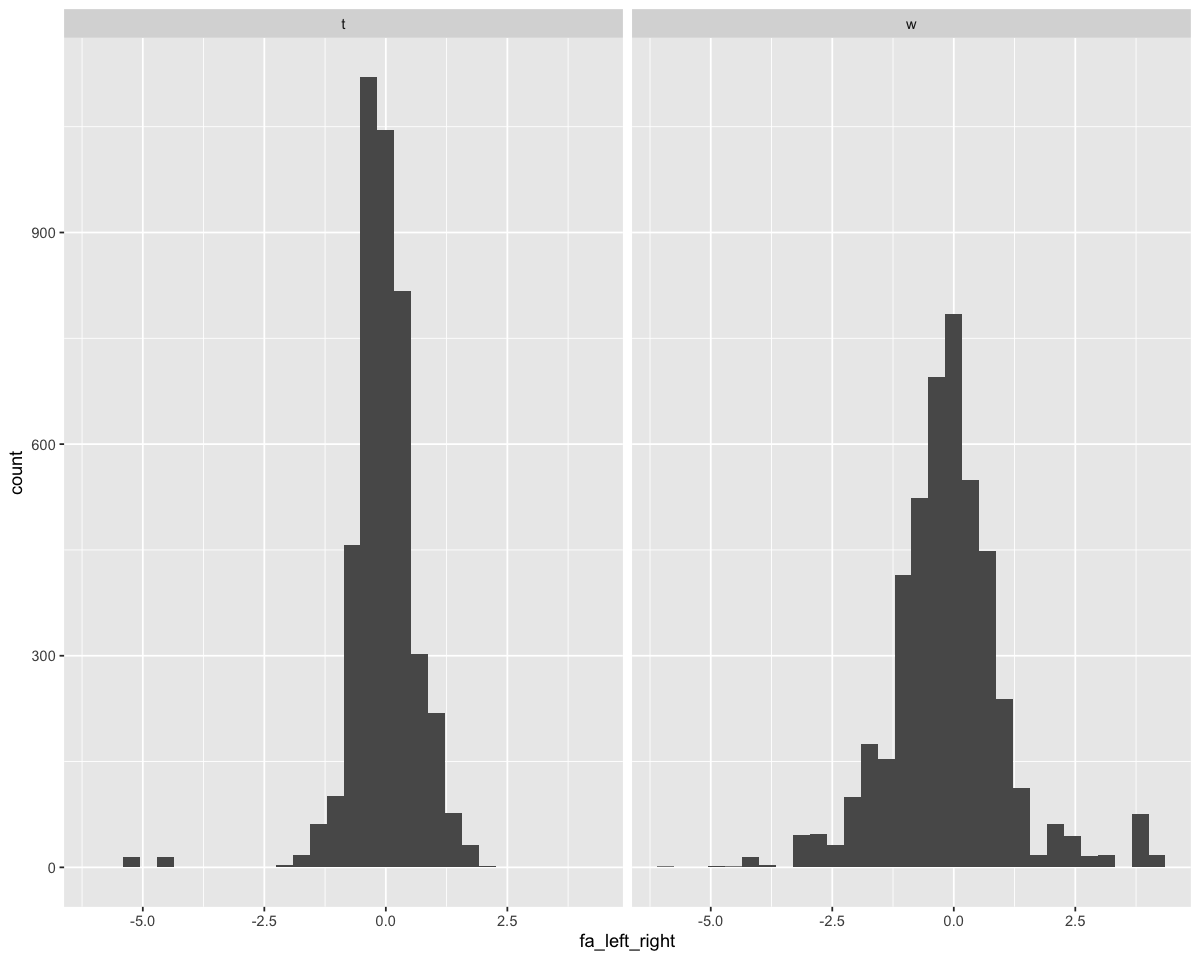

Warning message:
“Removed 40 rows containing non-finite values (stat_ydensity).”
Warning message in ggally_statistic(data = data, mapping = mapping, na.rm = na.rm, :
“Removed 2 rows containing missing values”
Warning message in ggally_statistic(data = data, mapping = mapping, na.rm = na.rm, :
“Removed 2 rows containing missing values”
Warning message:
“Removed 2 rows containing missing values (geom_point).”
Warning message:
“Removed 2 rows containing missing values (geom_point).”
Warning message:
“Removed 2 rows containing non-finite values (stat_density).”


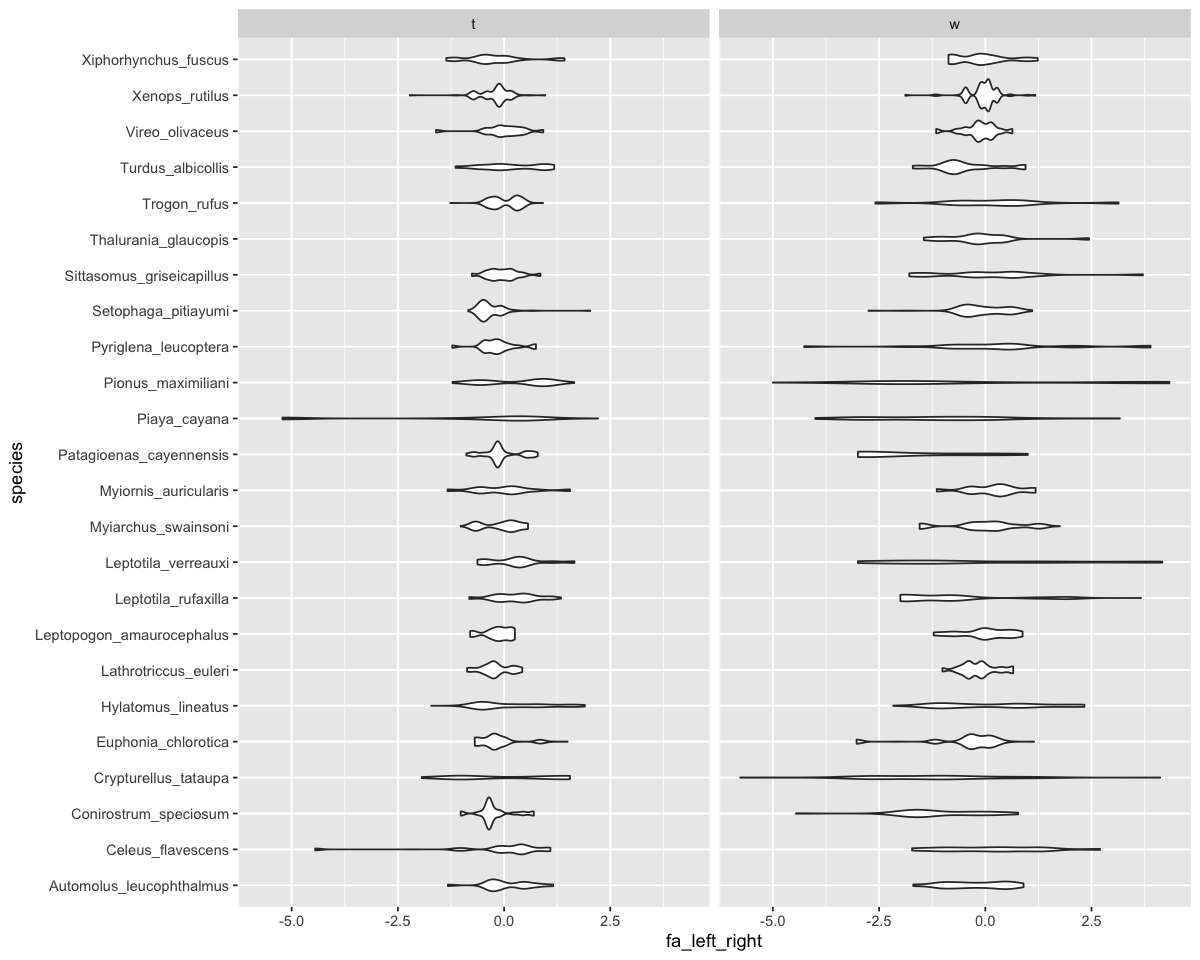

Warning message in ggally_statistic(data = data, mapping = mapping, na.rm = na.rm, :
“Removed 2 rows containing missing values”
Warning message in ggally_statistic(data = data, mapping = mapping, na.rm = na.rm, :
“Removed 2 rows containing missing values”
Warning message:
“Removed 2 rows containing missing values (geom_point).”
Warning message:
“Removed 2 rows containing missing values (geom_point).”
Warning message:
“Removed 2 rows containing non-finite values (stat_density).”


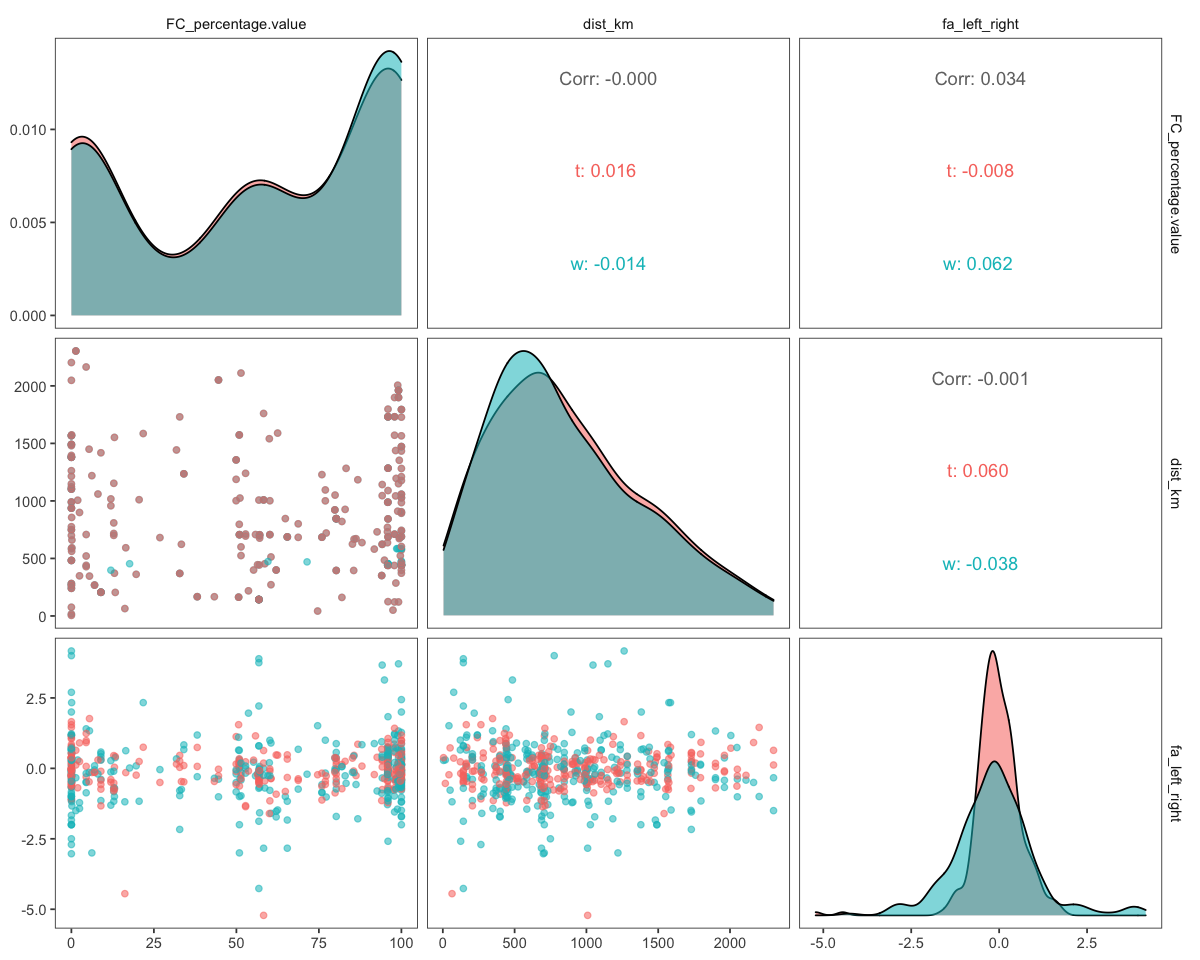

In [12]:
options(repr.plot.width=10, repr.plot.height=8)

plot_hist <- ggplot(FA_FC_data, aes(x=fa_left_right)) + 
              geom_histogram(bins = 30)+
              facet_wrap(~type)
plot_hist
ggsave("../2.results/plots/FA_left_right_hist.png", plot_hist, width = 7, height=7, units="in")

##
plot_violin <- ggplot(FA_FC_data, aes(x=fa_left_right, y=species)) + 
                geom_violin()+
                facet_wrap(~type)
plot_violin
ggsave("../2.results/plots/FA_left_right_per_species.png", plot_violin, width = 7, height=8, units="in")

##
plot_pairs <- FA_FC_data %>%
                filter(FC_buffer == 600) %>%
                ggpairs(columns = c('FC_percentage.value', 'dist_km', 'fa_left_right'), 
                    ggplot2::aes(colour=type, alpha=0.8))+
                    theme_article()
plot_pairs
ggsave("../2.results/plots/Fa_FC_600_dist.png", plot_pairs, width = 7, height=7, units="in")
 

I use the variance in the signed difference between L and R as a measure of FA. This is because it is suggested in this [paper](https://resjournals.onlinelibrary.wiley.com/doi/epdf/10.1046/j.1365-2311.2000.00204.x). I dont explicitly correct for size of the trait because according to this [other paper](http://www.biology.ualberta.ca/palmer.hp/asym/FA/Primer.pdf), page 25, '10.2 Test for size dependence of FA between samples' there seems to be no pattern in my data to justify the scaling ("Arbitrary correction for presumed size-dependence can lead to spurious differences among samples.

`geom_smooth()` using formula 'y ~ x'

Warning message:
“Removed 2 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 2 rows containing missing values (geom_point).”
`geom_smooth()` using formula 'y ~ x'

Warning message:
“Removed 2 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 2 rows containing missing values (geom_point).”


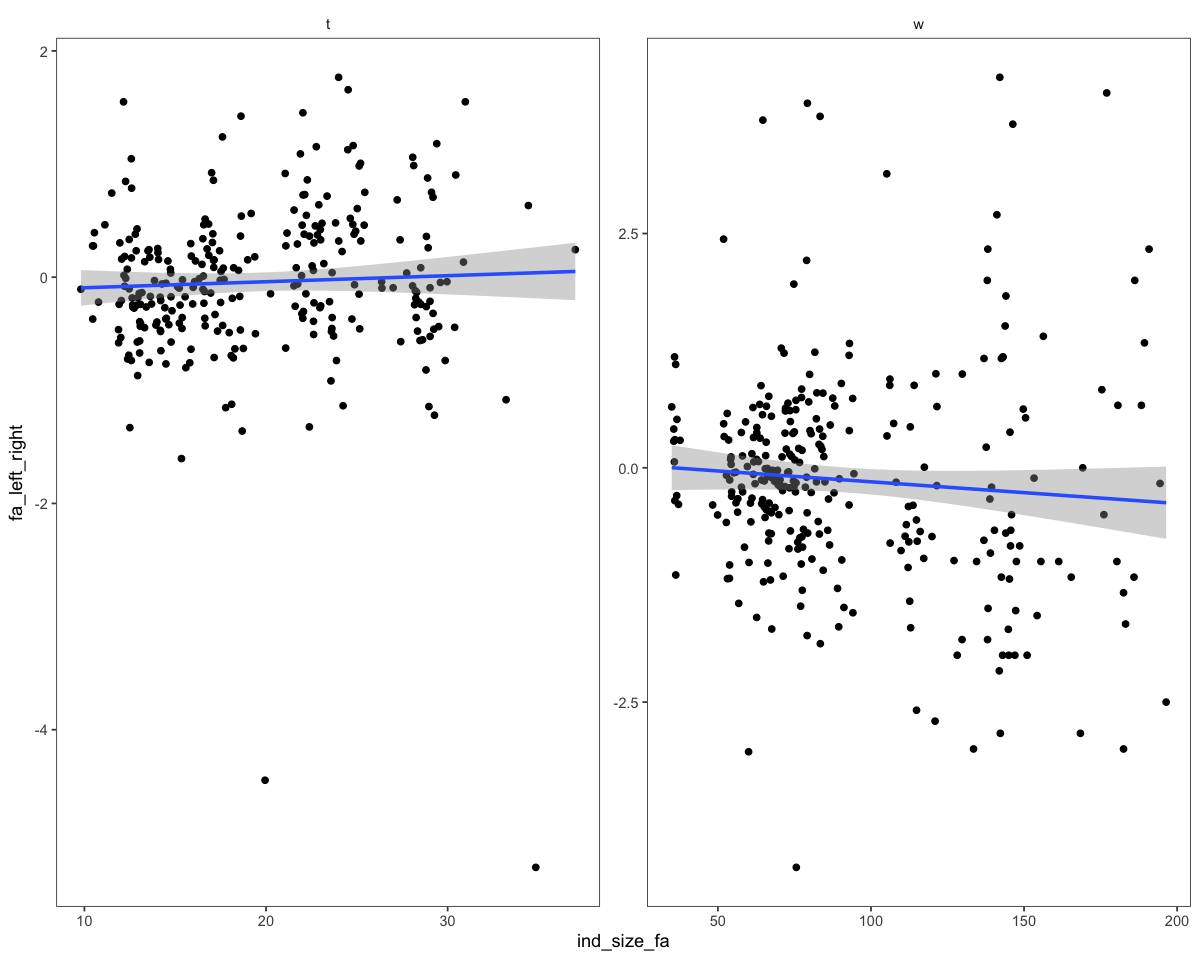

In [13]:
# regression of (R-L) against measure of body size

plot_FA_ind_size <- FA_FC_data %>%
        mutate(ind_size_fa = (mean_l + mean_r)/2)%>%
        filter(FC_buffer == 600) %>%
        ggplot(aes(x=ind_size_fa, y=fa_left_right))+
               geom_point()+
               geom_smooth(method = "lm")+
                facet_wrap(~type, scales = "free")+
                theme_article()

plot_FA_ind_size
ggsave("../2.results/plots/Fa_vs_ind_size.png",plot_FA_ind_size, width = 7, height=7, units="in")
 


## Model Fitting

Fit a model predicting variance as a function of distance to range edge plus a random effect of species on distance. Also filter out the individuals who are outside their range (sqrt_dist >0 )

In [14]:
FA_FC_data %>%
        write_csv("../FA_FC_final.csv")

In [15]:
FA_FC_data %>%
dplyr::filter(FC_buffer == 600)%>%
nrow()

FA_FC_data %>%
distinct(species)%>%
nrow()

FA_FC_data %>%
pull(date_collected)%>%
range()

[1] 574

[1] 24

[1] 1926 2017

### Bayesian models for FA (wing)

Running this in Tom's computer because mine is too slow.

Formula used is brm(bf(fa_left_right ~ 0, sigma ~ log(dist_km) + (log(dist_km)| species)).
The first term is relative to the mean, that I am not modelling because it doesn't make sense. As there is no directionality in the data, there will are no true differences between left and right, therefore the mean is zero. So I decided to model the variance, which is the second term of the formula (sigma).
The second term models the variance of FA with log of distance to the range edge as a fixed effect and a random effect consistent of a random intercept for distance and random slopes for species.

Using brms default priors  = weakly informative

In [16]:
load("..//2.results/bayesmodels.RData")
ls()

[1] "bay_mod_t"        "bay_mod_w"        "dist"             "FA"              
 [5] "FA_data"          "FA_FC_data"       "FC"               "plot_FA_ind_size"
 [9] "plot_hist"        "plot_pairs"       "plot_violin"

In [17]:
#set.seed(1)

#bay_mod_w <- FA_FC_data %>%
#filter(FC_buffer == 600, type == "w") %>%
#brm(bf(fa_left_right ~ 0, sigma ~ log(dist_km) + (log(dist_km) | species)),
#    data = .,
#    family = gaussian,
#    cores = 4, chains = 4, iter = 10000, 
#    control=list(adapt_delta = 0.99))

In [18]:
summary(bay_mod_w)

 Family: gaussian 
  Links: mu = identity; sigma = log 
Formula: fa_left_right ~ 0 
         sigma ~ log(dist_km) + (log(dist_km) | species)
   Data: . (Number of observations: 296) 
  Draws: 4 chains, each with iter = 10000; warmup = 5000; thin = 1;
         total post-warmup draws = 20000

Group-Level Effects: 
~species (Number of levels: 24) 
                                      Estimate Est.Error l-95% CI u-95% CI Rhat
sd(sigma_Intercept)                       1.48      0.94     0.18     3.59 1.00
sd(sigma_logdist_km)                      0.21      0.16     0.01     0.56 1.00
cor(sigma_Intercept,sigma_logdist_km)    -0.70      0.46    -0.99     0.72 1.00
                                      Bulk_ESS Tail_ESS
sd(sigma_Intercept)                       2293     6279
sd(sigma_logdist_km)                      1379     4061
cor(sigma_Intercept,sigma_logdist_km)     1907     5150

Population-Level Effects: 
                 Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sig

In [25]:
hypothesis(bay_mod_w, "sigma_logdist_km < 0")

Hypothesis Tests for class b:
              Hypothesis Estimate Est.Error CI.Lower CI.Upper Evid.Ratio
1 (sigma_logdist_km) < 0    -0.18      0.13    -0.38     0.03      12.14
  Post.Prob Star
1      0.92     
---
'CI': 90%-CI for one-sided and 95%-CI for two-sided hypotheses.
'*': For one-sided hypotheses, the posterior probability exceeds 95%;
for two-sided hypotheses, the value tested against lies outside the 95%-CI.
Posterior probabilities of point hypotheses assume equal prior probabilities.

In [26]:
FA_FC_data %>%
    group_by(species) %>%
    data_grid(dist = seq_range(log(dist_km), n = 100)) %>%
    add_predicted_draws(bay_mod_w)


#%>%
 #   ggplot(aes(x=dist, y=fa_left_right, color=species, fill=species))+
  #  stat_lineribbon(aes(y=.prediction), alpha=0.25)+
   # geom_point(data=FA_FC_data)+
   # scale_fill_brewer(palette = "Set2")+
   # sclae_color_brewer(palette = "Dark2")


ERROR: Error in eval(predvars, data, env): object 'dist_km' not found


pdf 
  2

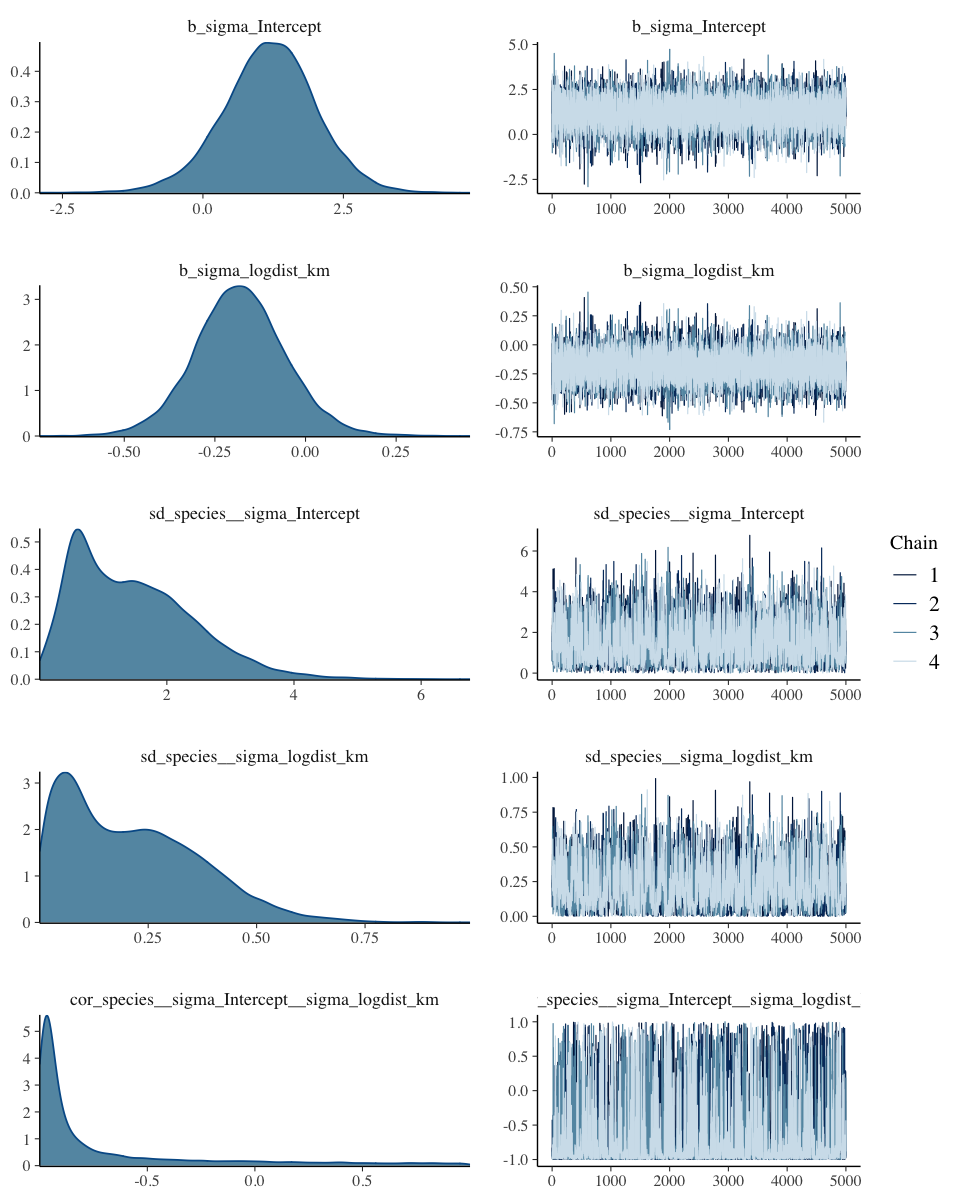

In [45]:
options(repr.plot.width=8, repr.plot.height=10)
plot(bay_mod_w)

png(file="../2.results/plots/bayes_w_coefs_chains.png", width=7, height = 10, units="in", res = 1200)
plot(bay_mod_w)
dev.off()


pdf 
  2

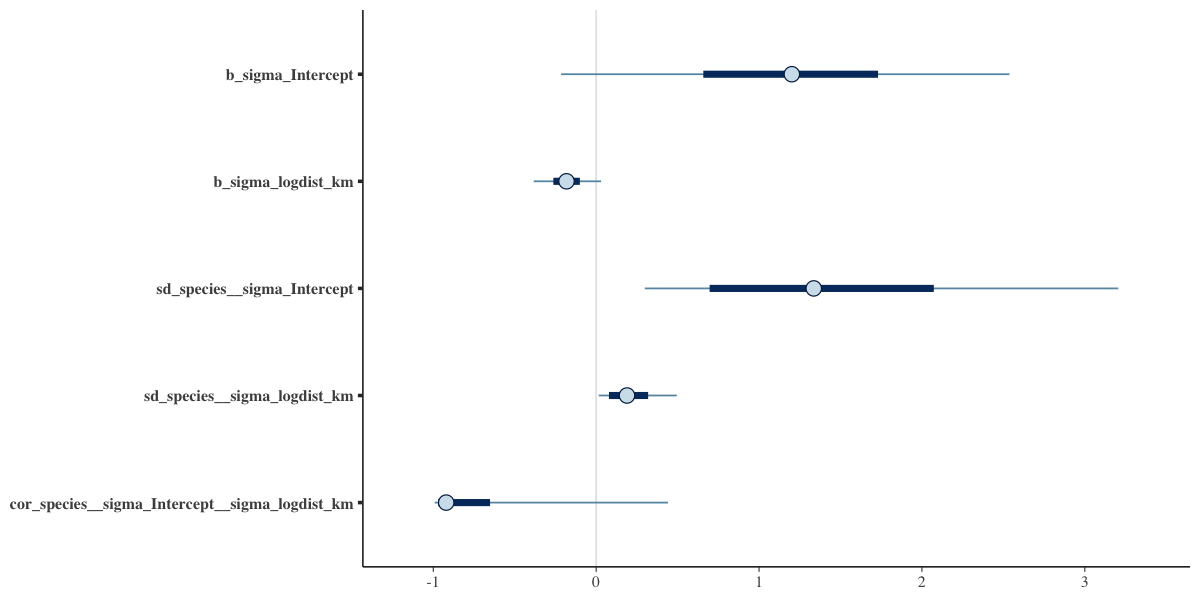

In [46]:
options(repr.plot.width=10, repr.plot.height=5)
mcmc_plot(bay_mod_w)

png(file="../2.results/plots/bayes_w_coef.png", width=7, height = 10, units="in", res = 1200)
mcmc_plot(bay_mod_w)
dev.off()


pdf 
  2

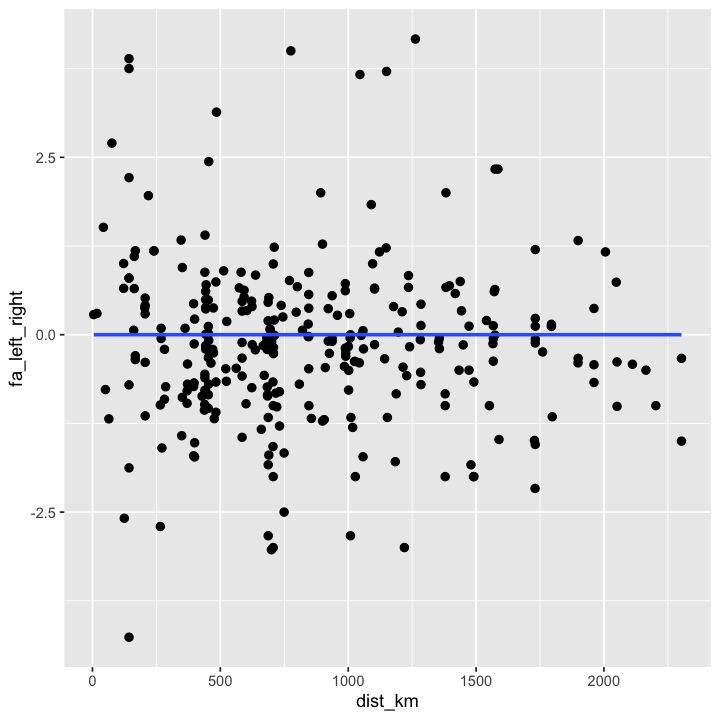

In [47]:
options(repr.plot.width=6, repr.plot.height=6)

plot(conditional_effects(bay_mod_w), points = TRUE)

png(file="../2.results/plots/bayes_w_cond_effects.png", width=7, height = 10, units="in", res = 1200)
plot(conditional_effects(bay_mod_w), points = TRUE)
dev.off()


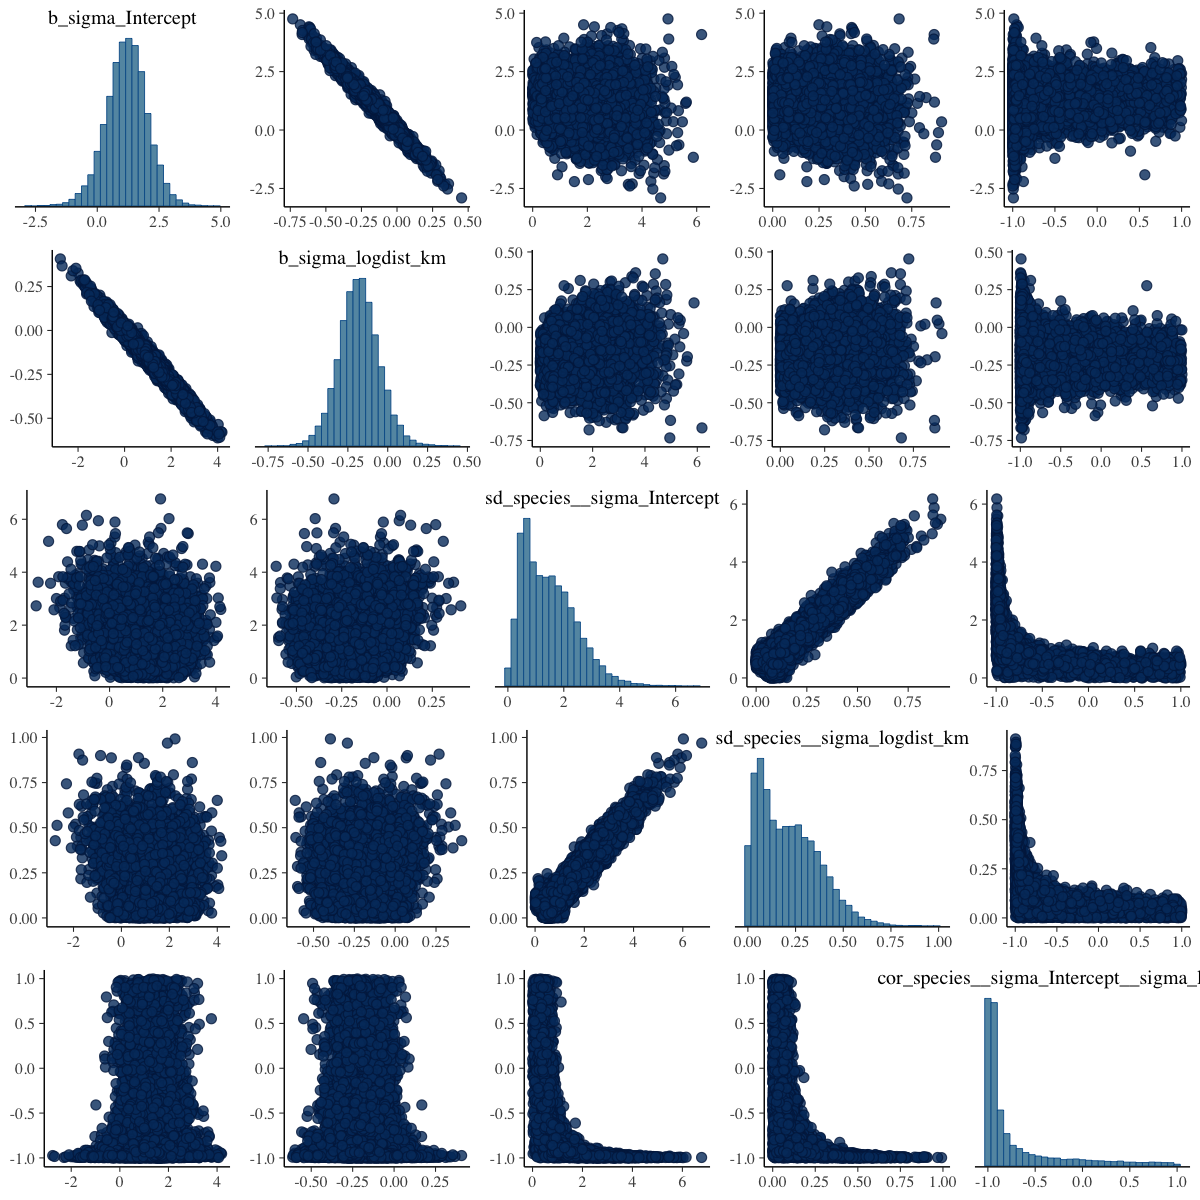

In [37]:
options(repr.plot.width=10, repr.plot.height=10)
pairs(bay_mod_w)

### Bayesian models for FA (tarsus)

Running this in Tom's computer because mine is too slow.

Formula used is brm(bf(fa_left_right ~ 0, sigma ~ log(dist_km) + (log(dist_km)| species)).
The first term is relative to the mean, that I am not modelling because it doesn't make sense. As there is no directionality in the data, there will are no true differences between left and right, therefore the mean is zero. So I decided to model the variance, which is the second term of the formula (sigma).
The second term models the variance of FA with log of distance to the range edge as a fixed effect and a random effect consistent of a random intercept for distance and random slopes for species.


Using brms default priors  = weakly informative

In [27]:
summary(bay_mod_t)

Warning message:
“There were 7 divergent transitions after warmup. Increasing adapt_delta above 0.99 may help. See http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup”


 Family: gaussian 
  Links: mu = identity; sigma = log 
Formula: fa_left_right ~ 0 
         sigma ~ log(dist_km) + (log(dist_km) | species)
   Data: . (Number of observations: 276) 
  Draws: 4 chains, each with iter = 10000; warmup = 5000; thin = 1;
         total post-warmup draws = 20000

Group-Level Effects: 
~species (Number of levels: 23) 
                                      Estimate Est.Error l-95% CI u-95% CI Rhat
sd(sigma_Intercept)                       1.39      0.82     0.24     3.29 1.00
sd(sigma_logdist_km)                      0.19      0.13     0.01     0.48 1.00
cor(sigma_Intercept,sigma_logdist_km)    -0.79      0.37    -1.00     0.48 1.00
                                      Bulk_ESS Tail_ESS
sd(sigma_Intercept)                       3143     6568
sd(sigma_logdist_km)                      2307     3949
cor(sigma_Intercept,sigma_logdist_km)     3855     6110

Population-Level Effects: 
                 Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sig

In [32]:
hypothesis(bay_mod_t, "sigma_logdist_km < 0")

Hypothesis Tests for class b:
              Hypothesis Estimate Est.Error CI.Lower CI.Upper Evid.Ratio
1 (sigma_logdist_km) < 0    -0.04      0.12    -0.23     0.18       1.74
  Post.Prob Star
1      0.64     
---
'CI': 90%-CI for one-sided and 95%-CI for two-sided hypotheses.
'*': For one-sided hypotheses, the posterior probability exceeds 95%;
for two-sided hypotheses, the value tested against lies outside the 95%-CI.
Posterior probabilities of point hypotheses assume equal prior probabilities.

pdf 
  2

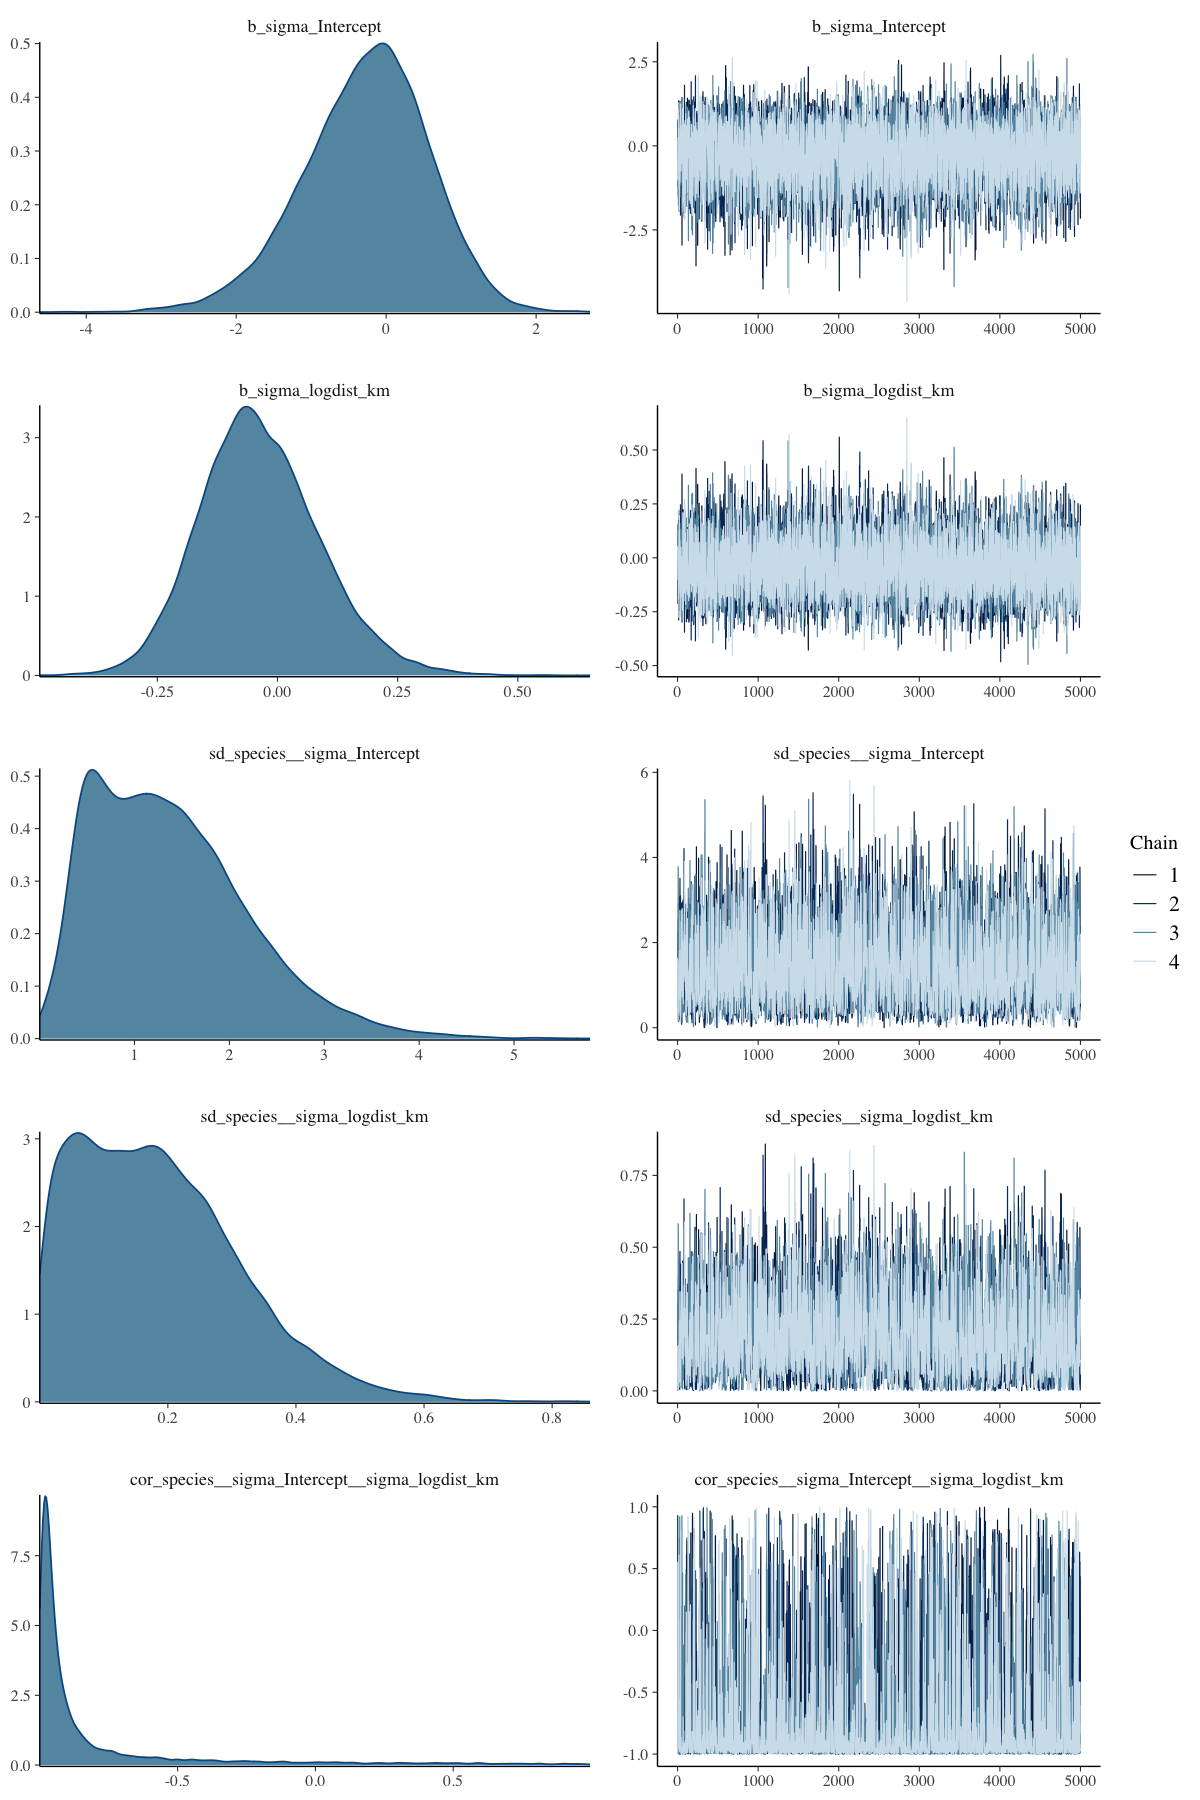

In [49]:
options(repr.plot.width=10, repr.plot.height=15)

plot(bay_mod_t)

png(file="../2.results/plots/bayes_t_coefs_chains.png", width=7, height = 10, units="in", res = 1200)
plot(bay_mod_t)
dev.off()

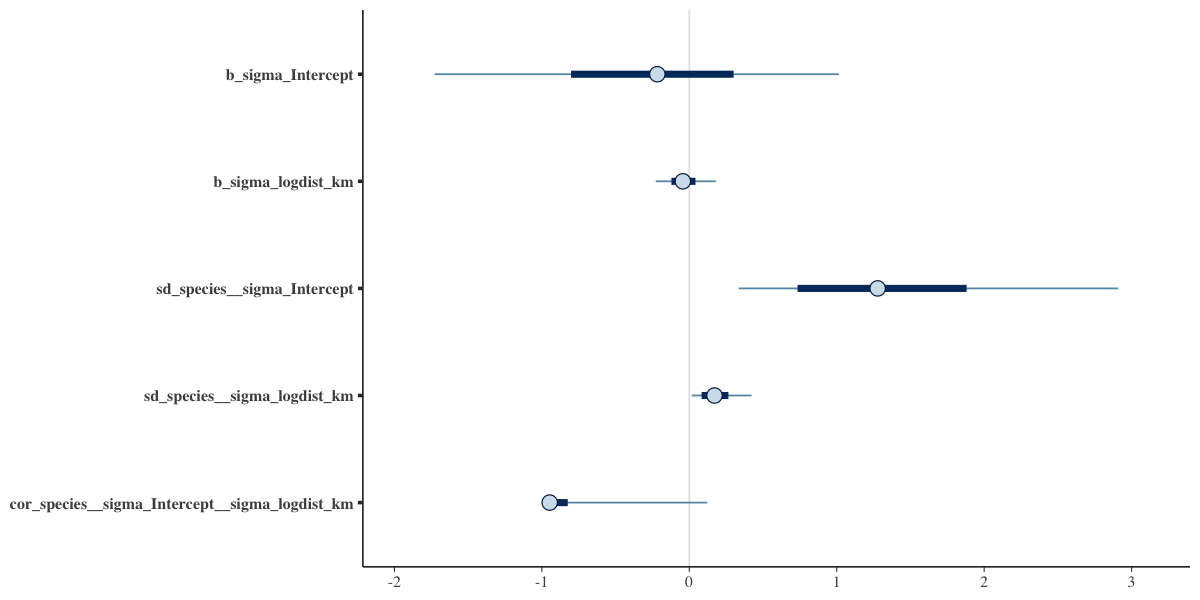

In [30]:
options(repr.plot.width=10, repr.plot.height=5)
mcmc_plot(bay_mod_t)

png(file="../2.results/plots/bayes_t_coef.png", width=7, height = 10, units="in", res = 1200)
mcmc_plot(bay_mod_t)
dev.off()

pdf 
  2

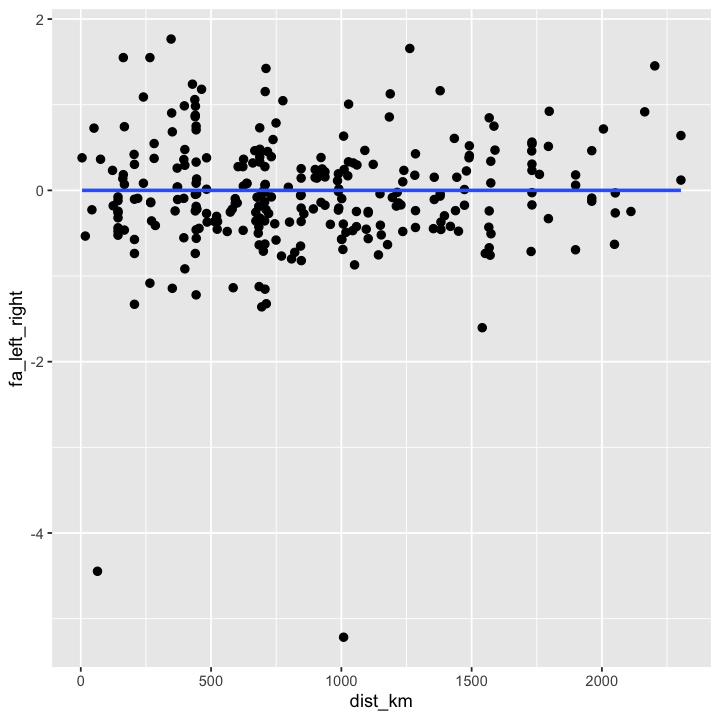

In [50]:
options(repr.plot.width=6, repr.plot.height=6)
plot(conditional_effects(bay_mod_t), points = TRUE)

png(file="../2.results/plots/bayes_t_cond_effects.png", width=7, height = 10, units="in", res = 1200)
plot(conditional_effects(bay_mod_t), points = TRUE)
dev.off()

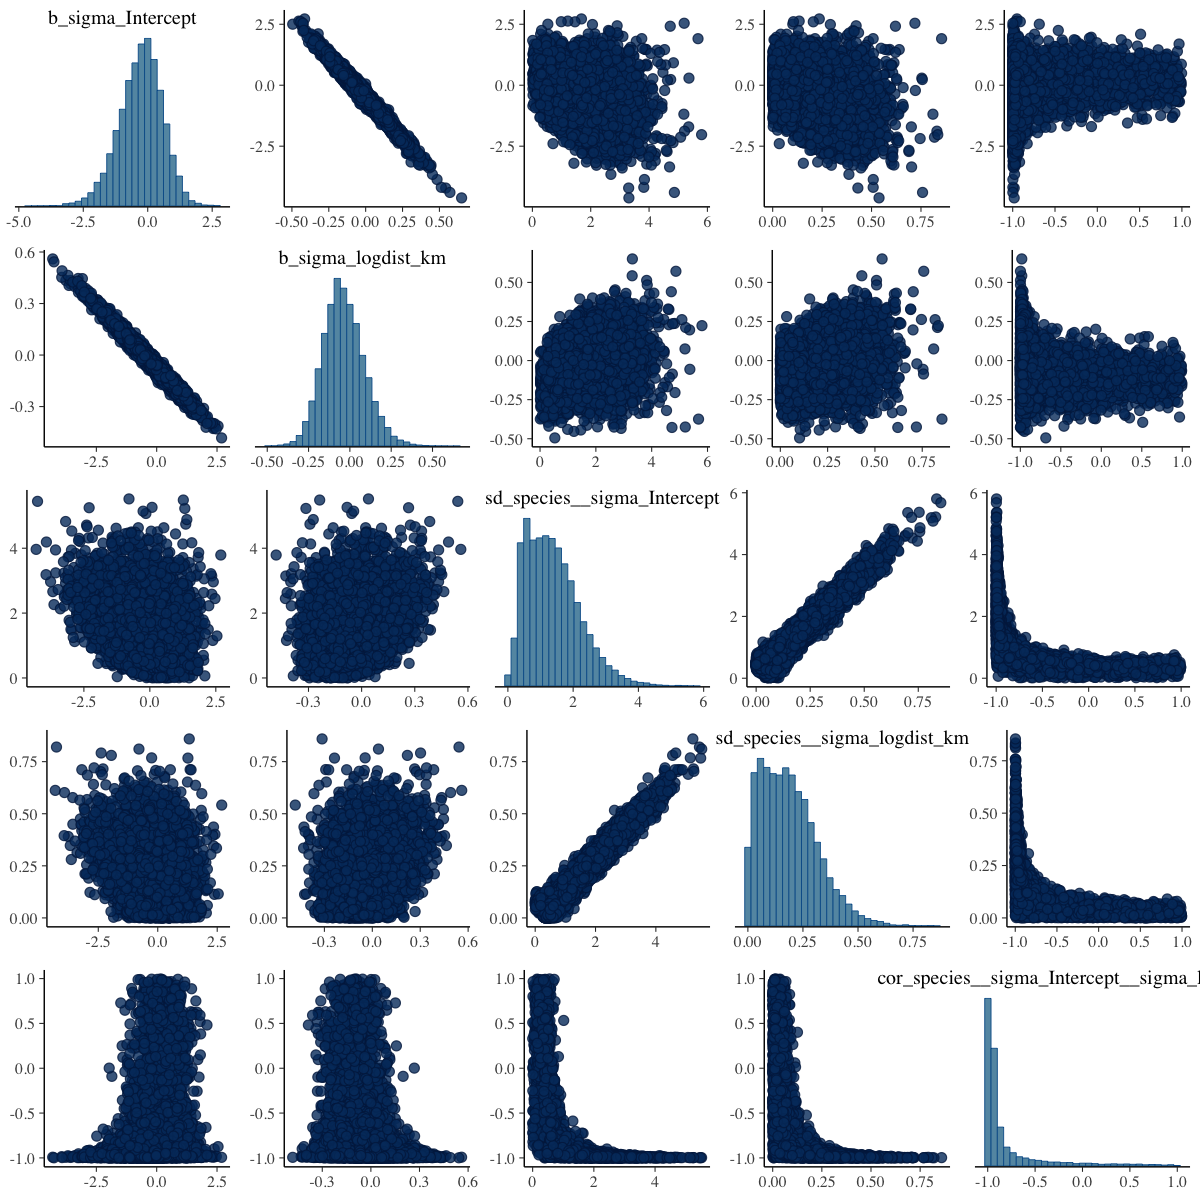

In [40]:
options(repr.plot.width=10, repr.plot.height=10)
pairs(bay_mod_t)

### Bayesian models for FA (wing) with FC

First look at FA ~ dist to edge + forest cover + random effects.

(I increased the adapt_delta from the default 0.8 to 0.9 due to divergent interactions)

# TOM
# CAN YOU RUN THIS FOR ME PLEASE? 

I think this might converge because FC porportion is more in line with the rest of the variables in terms of magnitude. 

In [55]:
set.seed(1)

bay_mod_w_FC <- FA_FC_data %>%
    filter(FC_buffer == 600, type == "w") %>%
    mutate(FC_proportion = FC_percentage.value/100) %>%
    brm(bf(fa_left_right ~ 0, sigma ~ FC_proportion * log(dist_km) + (log(dist_km) | species)),
        data = .,
        family = gaussian,
        cores = 4, chains = 4, iter = 10000, 
        control=list(adapt_delta = 0.99))


Compiling Stan program...

Start sampling

Warning message:
“There were 65 divergent transitions after warmup. See
http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup
to find out why this is a problem and how to eliminate them.”
Warning message:
“There were 1135 transitions after warmup that exceeded the maximum treedepth. Increase max_treedepth above 10. See
http://mc-stan.org/misc/warnings.html#maximum-treedepth-exceeded”
Warning message:
“Examine the pairs() plot to diagnose sampling problems
”


In [57]:
summary(bay_mod_W_FC)

ERROR: Error in h(simpleError(msg, call)): error in evaluating the argument 'object' in selecting a method for function 'summary': object 'bay_mod_W_FC' not found


In [ ]:
pairs(FA_w_FC_fit)

In [ ]:
plot(FA_w_FC_fit)

plot(conditional_effects(FA_w_FC_fit), points = TRUE)

In [ ]:
hypothesis(FA_w_FC_fit, "sqrt_dist < 0")

In [ ]:
hypothesis(FA_w_FC_fit, "FC_percentage.value < 0")

# IF THE PREVIOUS ONE WORKED, CAN YOU RUN IT FOR TARSUS TOO, PLEASE?

In [ ]:
set.seed(1)

bay_mod_t_FC <- FA_FC_data %>%
    filter(FC_buffer == 600, type == "t") %>%
    mutate(FC_proportion = FC_percentage.value/100) %>%
    brm(bf(fa_left_right ~ 0, sigma ~ FC_proportion * log(dist_km) + (log(dist_km) | species)),
        data = .,
        family = gaussian,
        cores = 4, chains = 4, iter = 10000, 
        control=list(adapt_delta = 0.99))


In [ ]:
summary(FA_t_FC_fit)

In [ ]:
plot(FA_t_FC_fit)

plot(conditional_effects(FA_t_FC_fit), points = TRUE)

In [ ]:
hypothesis(FA_t_FC_fit, "sqrt_dist < 0")

In [ ]:
hypothesis(FA_t_FC_fit, "FC_percentage.value < 0")

In [ ]:
save.image("../2.notebook/FA_analysis.RData")